install library yang dibutuhkan

In [ ]:
%pip install -r "../requirements.txt"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 70.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 76.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/

# Import Library

Code untuk melakukan import library library yang dibutuhkan

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import kornia.augmentation as K
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.models as models
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import rasterio
import datetime
from tqdm import tqdm
import time
from PIL import Image
import csv
import random
import pandas as pd
import zipfie

# Data Preparation

Inisialisasi Class Mempersiapkan Dataset

In [ ]:
class RandomAugmentation(nn.Module):
    def __init__(self):
        super().__init__()
        self.aug = nn.Sequential(
            K.RandomHorizontalFlip(p=0.5),
            K.RandomVerticalFlip(p=0.5),
            K.RandomRotation(degrees=(0, 360), p=0.5, resample="bilinear")
        )

    def forward(self, image, mask):
        # image: Tensor [C, H, W], mask: Tensor [H, W]
        image = image.unsqueeze(0)  # -> [1, C, H, W]
        mask  = mask.unsqueeze(0).unsqueeze(0).float()  # -> [1, 1, H, W]

        # Apply same transformation to both
        out = self.aug(torch.cat([image, mask], dim=1))  # [1, C+1, H, W]

        image_aug = out[:, :-1, :, :].squeeze(0)  # [C, H, W]
        mask_aug = out[:, -1, :, :].squeeze(0).long()  # [H, W]

        return image_aug, mask_aug

In [ ]:
# ========== 2. Dataset ==========
class SatelliteDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted([f for f in os.listdir(image_dir) if f.endswith(".tif")])
        self.masks  = sorted([f for f in os.listdir(mask_dir)  if f.endswith(".png")])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])

        # Read 16-bit image with rasterio
        with rasterio.open(img_path) as src:
            image = src.read().astype(np.float32) / 65535.0  # normalize

        image = torch.from_numpy(image).float()  # (C, H, W)

        # Load mask
        mask = np.array(Image.open(mask_path))
        mask = torch.tensor(mask, dtype=torch.long)  # (H, W)

        if self.transform:
            image, mask = self.transform(image, mask)

        return image, mask

Load Dataset

In [ ]:
image_dir = "dataset/dataset_16bit"
mask_dir = "dataset/label_index"

# Validasi apakah folder benar-benar ada
assert os.path.exists(image_dir), f"Folder gambar tidak ditemukan: {image_dir}"
assert os.path.exists(mask_dir), f"Folder label tidak ditemukan: {mask_dir}"

print("✅ Path valid. Siap melanjutkan...")

Train 80, Validation 20

In [ ]:
# ========== 3. Data Preparation ==========
full_dataset = SatelliteDataset(image_dir, mask_dir)

batch_size = 16

# Split 80% train, 20% validation
total_size = len(full_dataset)
val_size = int(0.2 * total_size)
train_size = total_size - val_size

generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size], generator=generator)

# Ganti transform hanya pada train_dataset
train_dataset.dataset.transform = RandomAugmentation()  # assign transform to dataset inside Subset

# ========== 4. DataLoaders ==========
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
print("Jumlah data latih:", len(train_dataset))
print("Jumlah data tes  :", len(test_dataset))

Jumlah data latih: 8100
Jumlah data tes  : 2025


In [ ]:
print("Total dataset:", len(SatelliteDataset(image_dir, mask_dir)))

Total dataset: 10125


# Modeling

SK-ResNeXt50 Encoder Code

In [ ]:
class SKConv(nn.Module):
    def __init__(self, channels, stride=1, groups=32, reduction=16):
        super(SKConv, self).__init__()
        d = max(channels // reduction, 4)

        # Two separate convolutional branches
        self.conv3 = nn.Conv2d(channels, channels, kernel_size=3, stride=stride, padding=1, groups=groups, bias=False)
        self.bn3 = nn.BatchNorm2d(channels)

        self.conv5 = nn.Conv2d(channels, channels, kernel_size=3, stride=stride, padding=2, dilation=2, groups=groups, bias=False)
        self.bn5 = nn.BatchNorm2d(channels)

        self.relu = nn.ReLU(inplace=True)

        # Squeeze-and-Excitation (SK attention)
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(channels, d, kernel_size=1, bias=False)
        self.fc2 = nn.Conv2d(d, channels * 2, kernel_size=1, bias=False)

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x3 = self.relu(self.bn3(self.conv3(x)))  # branch 1
        x5 = self.relu(self.bn5(self.conv5(x)))  # branch 2

        feats = torch.stack([x3, x5], dim=1)  # shape: (B, 2, C, H, W)

        # Fuse
        u = x3 + x5
        s = self.global_pool(u)
        z = self.fc1(s)
        a_b = self.fc2(z).view(x.size(0), 2, x.size(1), 1, 1)  # shape: (B, 2, C, 1, 1)
        a_b = self.softmax(a_b)

        out = (feats * a_b).sum(dim=1)
        return out


class resnext_block(nn.Module):
    def __init__(self, in_channels, cardinality, bwidth, idt_downsample=None, stride=1):
        super(resnext_block, self).__init__()
        self.expansion = 2
        out_channels = cardinality * bwidth

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        # Replaced conv2 with SKConv
        self.skconv = SKConv(out_channels, stride=stride, groups=cardinality)

        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)

        self.relu = nn.ReLU(inplace=True)
        self.identity_downsample = idt_downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.skconv(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        out += identity
        out = self.relu(out)
        return out

# == SKResNeXt50 Encoder ==
class SKResNeXt(nn.Module):
    def __init__(self, resnet_block, layers, cardinality, bwidth, img_channels, num_classes):
        super(SKResNeXt, self).__init__()
        self.in_channels = 64
        self.cardinality = cardinality
        self.bwidth = bwidth

        self.stem = nn.Sequential(
            nn.Conv2d(img_channels, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._layers(resnet_block, layers[0], stride=1)
        self.layer2 = self._layers(resnet_block, layers[1], stride=2)
        self.layer3 = self._layers(resnet_block, layers[2], stride=2)
        self.layer4 = self._layers(resnet_block, layers[3], stride=2)

    def forward(self, x):
        x0 = self.stem(x)
        x0p = self.maxpool(x0)
        x1 = self.layer1(x0p)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)

        return x0, x1, x2, x3, x4

    def _layers(self, block, blocks, stride):
        identity_downsample = None
        out_channels = self.cardinality * self.bwidth
        layers = []

        if stride != 1 or self.in_channels != out_channels * 2:
            identity_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * 2, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * 2)
            )

        layers.append(block(self.in_channels, self.cardinality, self.bwidth, identity_downsample, stride))
        self.in_channels = out_channels * 2

        for _ in range(1, blocks):
            layers.append(block(self.in_channels, self.cardinality, self.bwidth))

        self.bwidth *= 2
        return nn.Sequential(*layers)

def SKResNeXt50(img_channels=4, num_classes=6, cardinality=32, bwidth=4):
    return SKResNeXt(resnext_block, [3, 4, 6, 3], cardinality, bwidth, img_channels, num_classes)

Data Dependent Up Sampling

In [ ]:
# === DUpsampling ===
class DUpsampling(nn.Module):
    def __init__(self, inplanes, scale, num_class, pad=0):
        super(DUpsampling, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, num_class * scale * scale, kernel_size=1, padding=pad, bias=False)
        self.scale = scale

    def forward(self, x):
        x = self.conv1(x)
        N, C, H, W = x.size()
        x_permuted = x.permute(0, 2, 3, 1)
        x_permuted = x_permuted.contiguous().view(N, H, W * self.scale, C // self.scale)
        x_permuted = x_permuted.permute(0, 2, 1, 3)
        x_permuted = x_permuted.contiguous().view(N, W * self.scale, H * self.scale, C // (self.scale * self.scale))
        x = x_permuted.permute(0, 3, 2, 1)
        return x

Attention Module (AM)

In [ ]:
# === Attention Mechanisms ===
def l2_norm(x):
    return torch.einsum("bcn, bn->bcn", x, 1 / torch.norm(x, p=2, dim=-2))

class PositionLinearAttention(nn.Module):
    def __init__(self, in_places, eps=1e-6):
        super(PositionLinearAttention, self).__init__()
        self.gamma = nn.Parameter(torch.zeros(1))
        self.query_conv = nn.Conv2d(in_places, in_places // 8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_places, in_places // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_places, in_places, kernel_size=1)
        self.eps = eps

    def forward(self, x):
        batch_size, chnnels, width, height = x.size()
        Q = self.query_conv(x).view(batch_size, -1, width * height)
        K = self.key_conv(x).view(batch_size, -1, width * height)
        V = self.value_conv(x).view(batch_size, -1, width * height)

        Q = l2_norm(Q).permute(0, 2, 1)
        K = l2_norm(K)

        tailor_sum = 1 / (width * height + torch.einsum("bnc, bc->bn", Q, torch.sum(K, dim=-1) + self.eps))
        value_sum = torch.einsum("bcn->bc", V).unsqueeze(-1).expand(-1, chnnels, width * height)

        matrix = torch.einsum('bmn, bcn->bmc', K, V)
        matrix_sum = value_sum + torch.einsum("bnm, bmc->bcn", Q, matrix)

        weight_value = torch.einsum("bcn, bn->bcn", matrix_sum, tailor_sum)
        weight_value = weight_value.view(batch_size, chnnels, width, height)

        return (x + self.gamma * weight_value).contiguous()

class ChannelLinearAttention(nn.Module):
    def __init__(self, eps=1e-6):
        super(ChannelLinearAttention, self).__init__()
        self.gamma = nn.Parameter(torch.zeros(1))
        self.eps = eps

    def forward(self, x):
        batch_size, chnnels, width, height = x.size()
        Q = x.view(batch_size, chnnels, -1)
        K = x.view(batch_size, chnnels, -1)
        V = x.view(batch_size, chnnels, -1)

        Q = l2_norm(Q)
        K = l2_norm(K).permute(0, 2, 1)

        tailor_sum = 1 / (width * height + torch.einsum("bnc, bn->bc", K, torch.sum(Q, dim=-2) + self.eps))
        value_sum = torch.einsum("bcn->bn", V).unsqueeze(-1).permute(0, 2, 1).expand(-1, chnnels, width * height)
        matrix = torch.einsum('bcn, bnm->bcm', V, K)
        matrix_sum = value_sum + torch.einsum("bcm, bmn->bcn", matrix, Q)

        weight_value = torch.einsum("bcn, bc->bcn", matrix_sum, tailor_sum)
        weight_value = weight_value.view(batch_size, chnnels, height, width)

        return (x + self.gamma * weight_value).contiguous()

class AttentionBlock(nn.Module):
    def __init__(self, channels):
        super(AttentionBlock, self).__init__()
        self.position_attention = PositionLinearAttention(channels)
        self.channel_attention = ChannelLinearAttention()

    def forward(self, x):
        x = self.position_attention(x)
        x = self.channel_attention(x)
        return x

U-Net SK-ResNeXt50 Modifikasi

In [ ]:
# === U-Net SKResNeXt Decoder Modifikasi ===
class UNet_SKResNeXt50_Modifikasi(nn.Module):
    def __init__(self, in_channels=4, out_channels=6, cardinality=32, bwidth=4):
        super(UNet_SKResNeXt50_Modifikasi, self).__init__()
        self.encoder = SKResNeXt50(img_channels=in_channels, num_classes=out_channels, cardinality=cardinality, bwidth=bwidth)

        self.expansion_filter = (cardinality * bwidth) * 2

        self.up1 = DUpsampling(self.expansion_filter*8, 2, self.expansion_filter*4)
        self.dec1 = self.conv_block(self.expansion_filter*8, self.expansion_filter*4)
        self.dec1_att = AttentionBlock(self.expansion_filter*4)

        self.up2 = DUpsampling(self.expansion_filter*4, 2, self.expansion_filter*2)
        self.dec2 = self.conv_block(self.expansion_filter*4 + self.expansion_filter*4, self.expansion_filter*2)
        self.dec2_att = AttentionBlock(self.expansion_filter*2)

        self.up3 = DUpsampling(self.expansion_filter*2, 2, self.expansion_filter)
        self.dec3 = self.conv_block(self.expansion_filter*2 + self.expansion_filter*2 + self.expansion_filter*4, self.expansion_filter)
        self.dec3_att = AttentionBlock(self.expansion_filter)

        self.up4 = DUpsampling(self.expansion_filter, 2, 128)
        self.dec4 = self.conv_block(128 + 64 + self.expansion_filter + self.expansion_filter*2 + self.expansion_filter*4, 64)
        self.dec4_att = AttentionBlock(64)

        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def conv_block(self, in_c, out_c):
        return nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        # Encoder
        x0, x1, x2, x3, x4 = self.encoder(x)

        # Decoder with dense connections
        up1 = self.up1(x4)
        d1_input = torch.cat([up1, x3], dim=1)
        dec1_block = self.dec1(d1_input)
        dec1 = self.dec1_att(dec1_block)

        up2 = self.up2(dec1)
        d2_input = torch.cat([
            up2,
            x2,
            F.interpolate(dec1_block, size=x2.shape[2:], mode='bilinear', align_corners=False)
        ], dim=1)
        dec2_block = self.dec2(d2_input)
        dec2 = self.dec2_att(dec2_block)

        up3 = self.up3(dec2)
        d3_input = torch.cat([
            up3,
            x1,
            F.interpolate(dec2_block, size=x1.shape[2:], mode='bilinear', align_corners=False),
            F.interpolate(dec1_block, size=x1.shape[2:], mode='bilinear', align_corners=False)
        ], dim=1)
        dec3_block = self.dec3(d3_input)
        dec3 = self.dec3_att(dec3_block)

        up4 = self.up4(dec3)
        d4_input = torch.cat([
            up4,
            x0,
            F.interpolate(dec3_block, size=x0.shape[2:], mode='bilinear', align_corners=False),
            F.interpolate(dec2_block, size=x0.shape[2:], mode='bilinear', align_corners=False),
            F.interpolate(dec1_block, size=x0.shape[2:], mode='bilinear', align_corners=False)
        ], dim=1)
        dec4_block = self.dec4(d4_input)
        dec4 = self.dec4_att(dec4_block)

        # Final output
        out = self.out_conv(dec4)
        out = F.interpolate(out, size=x.shape[2:], mode='bilinear', align_corners=False)
        return out


# Train

In [ ]:
def pixel_accuracy(output, mask):
    """
    Menghitung pixel-wise accuracy untuk semantic segmentation.

    Args:
        output (torch.Tensor): Output dari model, shape (B, C, H, W)
        mask (torch.Tensor): Ground truth label, shape (B, H, W)

    Returns:
        float: Pixel accuracy (%)
    """
    # Ambil prediksi kelas (argmax di dimensi channel)
    preds = torch.argmax(output, dim=1)  # shape: (B, H, W)

    # Hitung jumlah piksel yang benar
    correct = (preds == mask).float().sum()
    total = mask.numel()

    return (correct / total).item() * 100

In [ ]:
def evaluate(model, val_loader, device, criterion):
    model.eval()
    total_acc = 0
    total_loss = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)

            loss = criterion(outputs, masks)
            acc = pixel_accuracy(outputs, masks)

            total_loss += loss.item()
            total_acc += acc

    avg_loss = total_loss / len(val_loader)
    avg_acc = total_acc / len(val_loader)
    return avg_loss, avg_acc

In [ ]:
# ========== Cek & Load Checkpoint ==========
def get_latest_checkpoint(checkpoint_dir):
    if not os.path.exists(checkpoint_dir):
        return None
    # checkpoints = [f for f in os.listdir(checkpoint_dir) if f.endswith('.pth')]
    checkpoints = [f for f in os.listdir(checkpoint_dir) if f.endswith('.pt')]
    if not checkpoints:
        return None
    checkpoints.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))
    return os.path.join(checkpoint_dir, checkpoints[-1])

In [ ]:
# ========== 3. Training Setup ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

model = UNet_SKResNeXt50_Modifikasi(in_channels=4, out_channels=6, cardinality=8, bwidth=14).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.0005)
num_epochs = 120

Device: cuda


In [ ]:
model.eval()

UNet_SKResNeXt50_Modifikasi(
  (encoder): SKResNeXt(
    (stem): Sequential(
      (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): resnext_block(
        (conv1): Conv2d(64, 112, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (skconv): SKConv(
          (conv3): Conv2d(112, 112, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8, bias=False)
          (bn3): BatchNorm2d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv5): Conv2d(112, 112, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2), groups=8, bias=False)
          (bn5): BatchNorm2d(11

In [ ]:
# Hitung total parameters model
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params

71621238

**Training**

Inisialisasi Output Path

In [ ]:
# Define name of folder output main path

output_path = "modifikasi_32x4d" #JANGAN LUPA GANTI INI

Output path

In [ ]:
# Paths
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
last_model_path = f"output/{output_path}/last_model/unet_skresnext50_modifikasiA_last.pt"
best_model_path = f"output/{output_path}/best_model/unet_skresnext50_modifikasiA_best.pt"
checkpoint_dir = f"output/{output_path}/checkpoint"
log_dir = f"output/{output_path}/logs"
log_path = os.path.join(log_dir, f"training_log_{timestamp}.txt")
csv_path = os.path.join(log_dir, "trainlog.csv")
csv_path_resume = os.path.join(log_dir, "trainlog_resume.csv")
diagram_dir = f"output/{output_path}/diagram"
inference_dir = f"output/{output_path}/inference"

# Ensure directories exist
os.makedirs(os.path.dirname(best_model_path), exist_ok=True)
os.makedirs(os.path.dirname(last_model_path), exist_ok=True)
os.makedirs(diagram_dir, exist_ok=True)
os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)
os.makedirs(inference_dir, exist_ok=True)

Inisialisasi Logging

In [6]:
log_lines = []
log_lines.append(f"🕒 Training Started: {timestamp}")
log_lines.append(f"Best Model Path: {best_model_path}")
log_lines.append(f"Checkpoint Directory: {checkpoint_dir}")
log_lines.append("")

Inisialisasi History Untuk Plot Diagram Garis Train dan Val

In [7]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

Training Loop

In [ ]:
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    epoch_acc = 0

    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)

    for images, masks in train_pbar:
        images, masks = images.to(device), masks.to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        acc = pixel_accuracy(outputs, masks)
        epoch_loss += loss.item()
        epoch_acc += acc

        train_pbar.set_postfix(loss=loss.item(), acc=acc)
        log_lines.append(f"Epoch {epoch+1} | Loss: {loss.item():.4f}, Acc: {acc:.2f}%")

    val_loss, val_acc = evaluate(model, val_loader, device, criterion)

    train_losses.append(epoch_loss / len(train_loader))
    train_accuracies.append(epoch_acc / len(train_loader))
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    with open(csv_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Epoch", "Train Loss", "Train Accuracy", "Val Loss", "Val Accuracy"])
        for i in range(len(train_losses)):
            writer.writerow([
                i + 1,
                train_losses[i],
                train_accuracies[i],
                val_losses[i],
                val_accuracies[i]
            ])

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ Model disimpan (Val Loss: {val_loss:.4f})")
        log_lines.append(f"✅ Model disimpan (Val Loss: {val_loss:.4f}) [Epoch {epoch+1}]")

    if (epoch + 1) % 10 == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch+1}.pth")
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': val_loss,
            'best_val_loss': best_val_loss
        }, checkpoint_path)
        print(f"💾 Checkpoint disimpan: {checkpoint_path}")
        log_lines.append(f"💾 Checkpoint disimpan: {checkpoint_path}")

    log_line = f"Epoch {epoch+1} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%"
    print(log_line)
    log_lines.append(log_line)

with open(log_path, "w") as f:
    f.write("\n".join(log_lines))
print(f"\n📄 Log training disimpan di: {log_path}")

torch.save(model.state_dict(), last_model_path)
print(f"📦 Model terakhir disimpan di: {last_model_path}")

Epoch 1/120: 100%|██████████| 507/507 [03:13<00:00,  2.62it/s, acc=68.4, loss=0.728]


✅ Model disimpan (Val Loss: 1.0306)
Epoch 1 | Val Loss: 1.0306 | Val Acc: 58.05%


Epoch 2/120: 100%|██████████| 507/507 [03:11<00:00,  2.65it/s, acc=74.6, loss=0.668]


Epoch 2 | Val Loss: 1.1639 | Val Acc: 60.17%


Epoch 3/120: 100%|██████████| 507/507 [03:10<00:00,  2.66it/s, acc=78.1, loss=0.691]


✅ Model disimpan (Val Loss: 0.9760)
Epoch 3 | Val Loss: 0.9760 | Val Acc: 64.17%


Epoch 4/120: 100%|██████████| 507/507 [03:11<00:00,  2.65it/s, acc=62.5, loss=0.859]


Epoch 4 | Val Loss: 1.0815 | Val Acc: 61.85%


Epoch 5/120: 100%|██████████| 507/507 [03:11<00:00,  2.65it/s, acc=74, loss=0.964]


✅ Model disimpan (Val Loss: 0.6502)
Epoch 5 | Val Loss: 0.6502 | Val Acc: 75.04%


Epoch 6/120: 100%|██████████| 507/507 [03:11<00:00,  2.64it/s, acc=63.8, loss=0.881]


Epoch 6 | Val Loss: 0.7128 | Val Acc: 71.99%


Epoch 7/120: 100%|██████████| 507/507 [03:11<00:00,  2.65it/s, acc=46.5, loss=1.03]


Epoch 7 | Val Loss: 0.8645 | Val Acc: 68.80%


Epoch 8/120: 100%|██████████| 507/507 [03:11<00:00,  2.65it/s, acc=79.8, loss=0.531]


✅ Model disimpan (Val Loss: 0.6063)
Epoch 8 | Val Loss: 0.6063 | Val Acc: 77.05%


Epoch 9/120: 100%|██████████| 507/507 [03:09<00:00,  2.67it/s, acc=71.3, loss=0.769]


✅ Model disimpan (Val Loss: 0.5468)
Epoch 9 | Val Loss: 0.5468 | Val Acc: 78.78%


Epoch 10/120: 100%|██████████| 507/507 [03:10<00:00,  2.66it/s, acc=47.9, loss=1.88]


💾 Checkpoint disimpan: /content/drive/MyDrive/KoTA-309/APE/APE-Train-2/output/modifikasi_8x14d_ru2/checkpoint/checkpoint_epoch_10.pth
Epoch 10 | Val Loss: 0.7041 | Val Acc: 73.74%


Epoch 11/120:   2%|▏         | 12/507 [00:04<03:22,  2.44it/s, acc=75.6, loss=0.621]


KeyboardInterrupt: 

In [ ]:
latest_checkpoint_path = get_latest_checkpoint(checkpoint_dir)
best_val_loss = float('inf')
start_epoch = 0

if latest_checkpoint_path:
    print(f"🔄 Melanjutkan training dari checkpoint: {latest_checkpoint_path}")
    checkpoint = torch.load(latest_checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    best_val_loss = checkpoint.get('best_val_loss', float('inf'))

for epoch in range(start_epoch, num_epochs):
    model.train()
    epoch_loss, epoch_acc = 0.0, 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)

    for images, masks in pbar:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        acc = pixel_accuracy(outputs, masks)
        epoch_loss += loss.item()
        epoch_acc += acc

        pbar.set_postfix(loss=loss.item(), acc=acc)

    # === Validasi ===
    val_loss, val_acc = evaluate(model, val_loader, device, criterion)  # Asumsinya juga % dari evaluate()

    # === Simpan history ke list ===
    train_losses.append(epoch_loss / len(train_loader))
    train_accuracies.append(epoch_acc / len(train_loader))
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # === Simpan ke CSV ===
    with open(csv_path_resume, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Epoch", "Train Loss", "Train Accuracy (%)", "Val Loss", "Val Accuracy (%)"])
        for i in range(len(train_losses)):
            writer.writerow([
                start_epoch + i + 1,
                train_losses[i],
                train_accuracies[i],
                val_losses[i],
                val_accuracies[i]
            ])

    # === Simpan Best Model ===
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ Best model updated at epoch {epoch+1}")
        log_lines.append(f"✅ Best model updated at epoch {epoch+1} | Val Loss: {val_loss:.4f}")

    # === Simpan Checkpoint setiap 20 epoch ===
    if (epoch + 1) % 10 == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch+1}.pt")
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss
        }, checkpoint_path)
        print(f"💾 Checkpoint disimpan: {checkpoint_path}")

    # === Logging ke terminal dan log_lines ===
    avg_train_loss = epoch_loss / len(train_loader)
    avg_train_acc = epoch_acc / len(train_loader)

    log_line = f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f}, Acc: {avg_train_acc:.2f}% | Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%"

    print(log_line)
    log_lines.append(log_line)

# ========== Simpan Model Terakhir ==========
torch.save(model.state_dict(), last_model_path)
print(f"📦 Model terakhir disimpan: {last_model_path}")

# ========== Simpan Log ke TXT ==========
with open(log_path, "w") as f:
    f.write("\n".join(log_lines))
print(f"📝 Log disimpan: {log_path}")


🔄 Melanjutkan training dari checkpoint: /content/drive/MyDrive/KoTA-309/APE/APE-Train-2/output/modifikasi_8x14d_run2/checkpoint/checkpoint_epoch_80.pt


Epoch 81/120: 100%|██████████| 507/507 [03:13<00:00,  2.62it/s, acc=83.4, loss=0.43]


Epoch 81 | Train Loss: 0.4022, Acc: 84.58% | Val Loss: 0.4223, Acc: 83.49%


Epoch 82/120: 100%|██████████| 507/507 [03:12<00:00,  2.64it/s, acc=81.3, loss=0.397]


Epoch 82 | Train Loss: 0.3953, Acc: 84.74% | Val Loss: 0.4685, Acc: 82.45%


Epoch 83/120: 100%|██████████| 507/507 [03:12<00:00,  2.64it/s, acc=90.7, loss=0.258]


Epoch 83 | Train Loss: 0.3951, Acc: 84.81% | Val Loss: 0.4984, Acc: 81.87%


Epoch 84/120: 100%|██████████| 507/507 [03:12<00:00,  2.64it/s, acc=68.4, loss=0.65]


Epoch 84 | Train Loss: 0.4171, Acc: 84.72% | Val Loss: 0.4769, Acc: 82.94%


Epoch 85/120: 100%|██████████| 507/507 [03:11<00:00,  2.64it/s, acc=84.7, loss=0.478]


Epoch 85 | Train Loss: 0.4175, Acc: 84.22% | Val Loss: 0.4569, Acc: 82.75%


Epoch 86/120: 100%|██████████| 507/507 [03:12<00:00,  2.64it/s, acc=82.5, loss=0.485]


Epoch 86 | Train Loss: 0.4433, Acc: 83.21% | Val Loss: 0.5461, Acc: 79.57%


Epoch 87/120: 100%|██████████| 507/507 [03:11<00:00,  2.64it/s, acc=76.9, loss=0.546]


Epoch 87 | Train Loss: 0.4577, Acc: 83.14% | Val Loss: 0.7012, Acc: 81.63%


Epoch 88/120: 100%|██████████| 507/507 [03:12<00:00,  2.64it/s, acc=84.4, loss=0.458]


Epoch 88 | Train Loss: 0.4983, Acc: 83.55% | Val Loss: 0.8984, Acc: 77.24%


Epoch 89/120: 100%|██████████| 507/507 [03:12<00:00,  2.64it/s, acc=86, loss=0.469]


Epoch 89 | Train Loss: 0.4977, Acc: 82.10% | Val Loss: 0.4443, Acc: 83.10%


Epoch 90/120: 100%|██████████| 507/507 [03:11<00:00,  2.65it/s, acc=87.6, loss=0.372]


💾 Checkpoint disimpan: /content/drive/MyDrive/KoTA-309/APE/APE-Train-2/output/modifikasi_8x14d_run2/checkpoint/checkpoint_epoch_90.pt
Epoch 90 | Train Loss: 0.4286, Acc: 83.77% | Val Loss: 0.4706, Acc: 82.08%


Epoch 91/120: 100%|██████████| 507/507 [03:12<00:00,  2.63it/s, acc=87, loss=0.364]


Epoch 91 | Train Loss: 0.4258, Acc: 83.67% | Val Loss: 0.4922, Acc: 81.37%


Epoch 92/120: 100%|██████████| 507/507 [03:11<00:00,  2.64it/s, acc=88, loss=0.376]


Epoch 92 | Train Loss: 0.4392, Acc: 83.67% | Val Loss: 0.4694, Acc: 81.93%


Epoch 93/120: 100%|██████████| 507/507 [03:11<00:00,  2.64it/s, acc=53.7, loss=0.89]


Epoch 93 | Train Loss: 0.5663, Acc: 83.03% | Val Loss: 0.4352, Acc: 83.01%


Epoch 94/120: 100%|██████████| 507/507 [03:11<00:00,  2.65it/s, acc=74.9, loss=0.517]


Epoch 94 | Train Loss: 0.4203, Acc: 83.87% | Val Loss: 0.4973, Acc: 81.09%


Epoch 95/120: 100%|██████████| 507/507 [03:12<00:00,  2.64it/s, acc=73.1, loss=0.64]


Epoch 95 | Train Loss: 0.4431, Acc: 83.05% | Val Loss: 0.4567, Acc: 82.51%


Epoch 96/120: 100%|██████████| 507/507 [03:12<00:00,  2.64it/s, acc=73.2, loss=0.537]


Epoch 96 | Train Loss: 0.4654, Acc: 82.32% | Val Loss: 0.5256, Acc: 79.50%


Epoch 97/120: 100%|██████████| 507/507 [03:12<00:00,  2.64it/s, acc=83.5, loss=0.558]


Epoch 97 | Train Loss: 0.5028, Acc: 81.79% | Val Loss: 0.4867, Acc: 81.44%


Epoch 98/120: 100%|██████████| 507/507 [03:11<00:00,  2.64it/s, acc=78.5, loss=0.584]


Epoch 98 | Train Loss: 0.4526, Acc: 82.55% | Val Loss: 0.4436, Acc: 82.96%


Epoch 99/120: 100%|██████████| 507/507 [03:11<00:00,  2.65it/s, acc=80.3, loss=0.524]


Epoch 99 | Train Loss: 0.4681, Acc: 82.58% | Val Loss: 0.5997, Acc: 79.87%


Epoch 100/120: 100%|██████████| 507/507 [03:11<00:00,  2.64it/s, acc=83.4, loss=0.447]


💾 Checkpoint disimpan: /content/drive/MyDrive/KoTA-309/APE/APE-Train-2/output/modifikasi_8x14d_run2/checkpoint/checkpoint_epoch_100.pt
Epoch 100 | Train Loss: 0.5100, Acc: 80.40% | Val Loss: 0.5283, Acc: 80.09%


Epoch 101/120: 100%|██████████| 507/507 [03:12<00:00,  2.64it/s, acc=48.6, loss=1.07]


Epoch 101 | Train Loss: 0.6670, Acc: 80.55% | Val Loss: 0.4796, Acc: 81.80%


Epoch 102/120: 100%|██████████| 507/507 [03:11<00:00,  2.65it/s, acc=91.5, loss=0.238]


Epoch 102 | Train Loss: 0.4754, Acc: 81.93% | Val Loss: 0.4496, Acc: 82.61%


Epoch 103/120: 100%|██████████| 507/507 [03:12<00:00,  2.64it/s, acc=74.9, loss=0.584]


Epoch 103 | Train Loss: 0.4446, Acc: 82.84% | Val Loss: 0.4807, Acc: 83.21%


Epoch 104/120: 100%|██████████| 507/507 [03:14<00:00,  2.61it/s, acc=77.5, loss=0.861]


Epoch 104 | Train Loss: 0.4334, Acc: 83.86% | Val Loss: 0.4275, Acc: 83.42%


Epoch 105/120: 100%|██████████| 507/507 [03:14<00:00,  2.61it/s, acc=92.5, loss=0.292]


Epoch 105 | Train Loss: 0.4127, Acc: 84.07% | Val Loss: 0.4474, Acc: 83.05%


Epoch 106/120: 100%|██████████| 507/507 [03:12<00:00,  2.64it/s, acc=76.3, loss=0.585]


Epoch 106 | Train Loss: 0.4181, Acc: 83.98% | Val Loss: 0.4918, Acc: 81.13%


Epoch 107/120: 100%|██████████| 507/507 [03:11<00:00,  2.64it/s, acc=75.1, loss=0.524]


Epoch 107 | Train Loss: 0.4517, Acc: 83.04% | Val Loss: 0.4653, Acc: 82.50%


Epoch 108/120: 100%|██████████| 507/507 [03:11<00:00,  2.65it/s, acc=68.2, loss=0.717]


Epoch 108 | Train Loss: 0.4414, Acc: 83.32% | Val Loss: 0.4468, Acc: 83.09%


Epoch 109/120: 100%|██████████| 507/507 [03:11<00:00,  2.64it/s, acc=72.5, loss=0.639]


Epoch 109 | Train Loss: 0.4734, Acc: 84.08% | Val Loss: 0.5301, Acc: 79.51%


Epoch 110/120: 100%|██████████| 507/507 [03:11<00:00,  2.65it/s, acc=78.1, loss=0.605]


💾 Checkpoint disimpan: /content/drive/MyDrive/KoTA-309/APE/APE-Train-2/output/modifikasi_8x14d_run2/checkpoint/checkpoint_epoch_110.pt
Epoch 110 | Train Loss: 0.5173, Acc: 83.47% | Val Loss: 0.4560, Acc: 82.46%


Epoch 111/120: 100%|██████████| 507/507 [03:11<00:00,  2.64it/s, acc=74.8, loss=0.72]


Epoch 111 | Train Loss: 0.4308, Acc: 83.67% | Val Loss: 0.5280, Acc: 79.82%


Epoch 112/120: 100%|██████████| 507/507 [03:12<00:00,  2.64it/s, acc=86.1, loss=0.521]


Epoch 112 | Train Loss: 0.4707, Acc: 82.85% | Val Loss: 0.5083, Acc: 80.61%


Epoch 113/120: 100%|██████████| 507/507 [03:13<00:00,  2.62it/s, acc=73.8, loss=0.601]


Epoch 113 | Train Loss: 0.4622, Acc: 82.61% | Val Loss: 0.4609, Acc: 82.35%


Epoch 114/120: 100%|██████████| 507/507 [03:13<00:00,  2.62it/s, acc=78.7, loss=0.555]


Epoch 114 | Train Loss: 0.4328, Acc: 83.44% | Val Loss: 0.4949, Acc: 81.04%


Epoch 115/120: 100%|██████████| 507/507 [03:12<00:00,  2.63it/s, acc=84, loss=0.406]


Epoch 115 | Train Loss: 0.4230, Acc: 83.62% | Val Loss: 0.4451, Acc: 82.91%


Epoch 116/120: 100%|██████████| 507/507 [03:12<00:00,  2.63it/s, acc=75.8, loss=0.597]


Epoch 116 | Train Loss: 0.4391, Acc: 83.19% | Val Loss: 0.4619, Acc: 82.28%


Epoch 117/120: 100%|██████████| 507/507 [03:12<00:00,  2.63it/s, acc=70.3, loss=0.686]


Epoch 117 | Train Loss: 0.4276, Acc: 83.69% | Val Loss: 0.4744, Acc: 82.21%


Epoch 118/120: 100%|██████████| 507/507 [03:12<00:00,  2.63it/s, acc=80.2, loss=0.442]


Epoch 118 | Train Loss: 0.4440, Acc: 83.32% | Val Loss: 0.4587, Acc: 82.56%


Epoch 119/120: 100%|██████████| 507/507 [03:12<00:00,  2.64it/s, acc=63.6, loss=1.09]


Epoch 119 | Train Loss: 0.4998, Acc: 83.04% | Val Loss: 0.4622, Acc: 82.19%


Epoch 120/120: 100%|██████████| 507/507 [03:13<00:00,  2.63it/s, acc=89.7, loss=0.275]


💾 Checkpoint disimpan: /content/drive/MyDrive/KoTA-309/APE/APE-Train-2/output/modifikasi_8x14d_run2/checkpoint/checkpoint_epoch_120.pt
Epoch 120 | Train Loss: 0.4446, Acc: 83.14% | Val Loss: 0.4940, Acc: 81.88%
📦 Model terakhir disimpan: /content/drive/MyDrive/KoTA-309/APE/APE-Train-2/output/modifikasi_8x14d_run2/last_model/unet_skresnext50_modifikasiA_last.pt
📝 Log disimpan: /content/drive/MyDrive/KoTA-309/APE/APE-Train-2/output/modifikasi_8x14d_run2/logs/training_log_20250622_225550.txt


Load Model

In [ ]:
# Load Model GPU
model.load_state_dict(torch.load(best_model_path))

# Load Model CPU
# model.load_state_dict(torch.load(last_model_path, map_location=torch.device('cpu')))

model.eval()

UNet_SKResNeXt50_Modifikasi(
  (encoder): SKResNeXt(
    (stem): Sequential(
      (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): resnext_block(
        (conv1): Conv2d(64, 112, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (skconv): SKConv(
          (conv3): Conv2d(112, 112, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8, bias=False)
          (bn3): BatchNorm2d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv5): Conv2d(112, 112, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2), groups=8, bias=False)
          (bn5): BatchNorm2d(11

# Evaluasi Model

#### Plot Loss and Plot Akurasi dari variabel history train

Plot Loss

ValueError: x and y must have same first dimension, but have shapes (100,) and (41,)

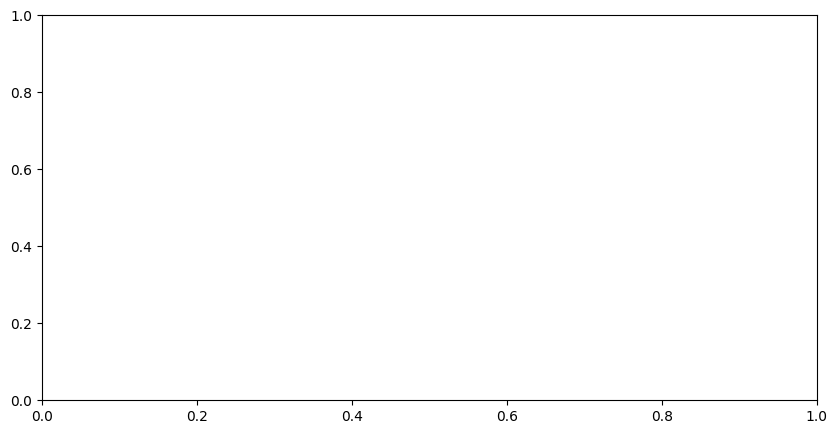

In [ ]:
# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig(f'output/{output_path}/diagram/loss_plot.png')
plt.show()

Plot Accuracy

ValueError: x and y must have same first dimension, but have shapes (100,) and (41,)

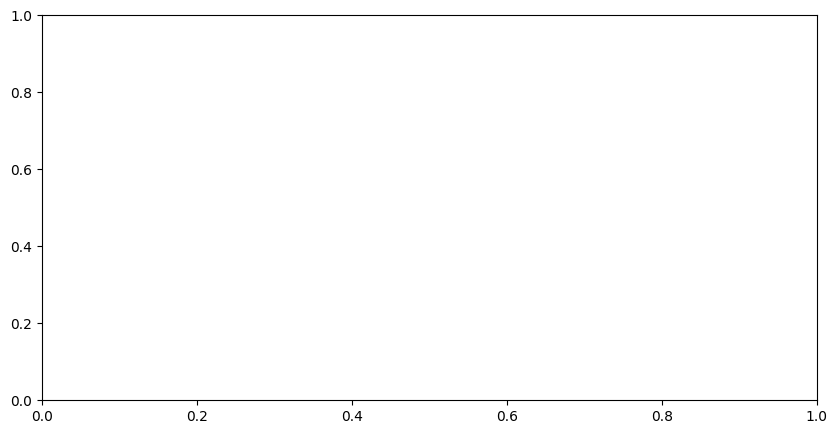

In [ ]:
# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.savefig(f'output/{output_path}/diagram/accuracy_plot.png')
plt.show()

#### Plot Loss and Plot Akurasi dari log csv

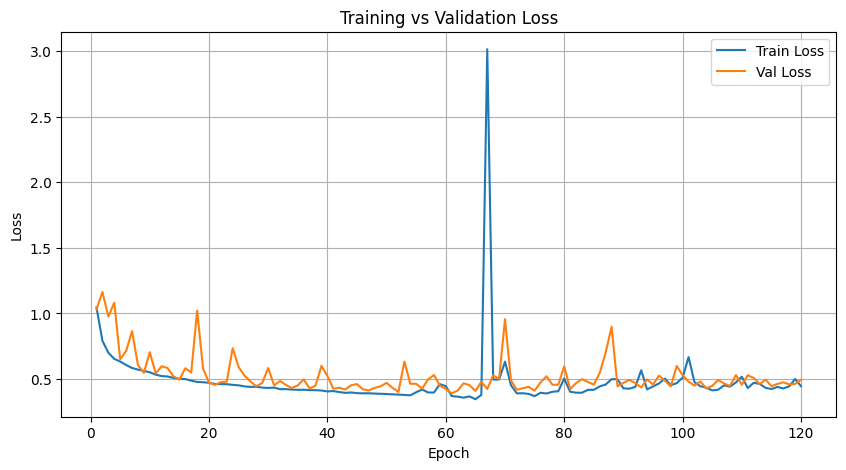

In [ ]:
# Ganti dengan path ke file CSV kamu jika file sudah disimpan
csv_file = f'output/{output_path}/logs/trainlog.csv'

# Membaca file CSV
df = pd.read_csv(csv_file)

# Ekstrak data
num_epochs = len(df)
train_losses = df['Train Loss']
val_losses = df['Val Loss']
train_accuracies = df['Train Accuracy']
val_accuracies = df['Val Accuracy']

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig(f'output/{output_path}/diagram/loss_plot.png')
plt.show()


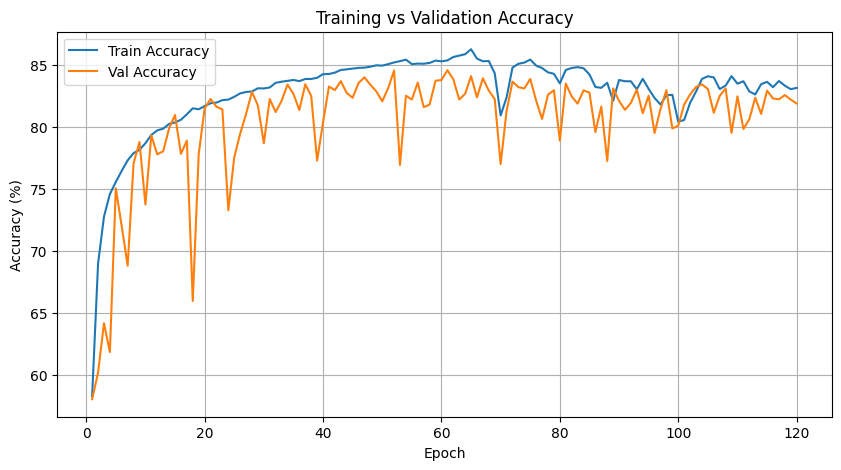

In [ ]:
# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.savefig(f'output/{output_path}/diagram/accuracy_plot.png')
plt.show()